<a href="https://colab.research.google.com/github/GiancarloSaran/LaboratoryOfComputationalPhysics_Y6/blob/main/10ex_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [3]:
tau = 3.052*60
N = 1000
# pb+tl=N conservation law
t = np.arange(2500)
pb1 = N*(1-np.power(2, -t/tau))
tl1 = N-pb1

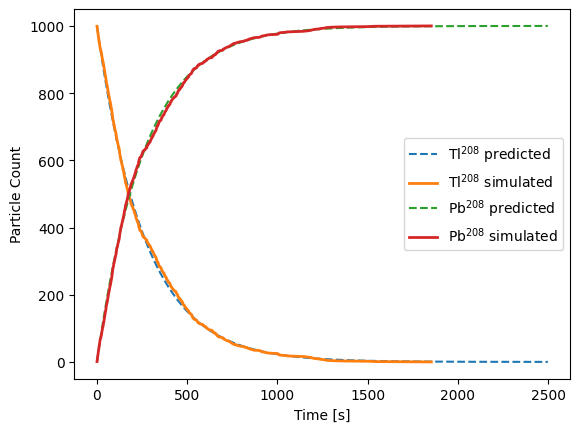

In [4]:
def expon_icdf(z, mu=1):
    return -np.log2(1-z)/mu

u = npr.random(1000)
tdec = expon_icdf(u, mu=1/tau)
tdec = np.sort(tdec)
tl = np.arange(1000)[::-1]
pb = N-tl
fig, ax = plt.subplots()
ax.plot(t, tl1, '--', linewidth=1.5, label='Tl$^{208}$ predicted')
ax.plot(tdec, tl, linewidth=2, label='Tl$^{208}$ simulated')
ax.plot(t, pb1, '--', linewidth=1.5, label='Pb$^{208}$ predicted')
ax.plot(tdec, pb, linewidth=2, label='Pb$^{208}$ simulated')
plt.xlabel('Time [s]')
plt.ylabel('Particle Count')
plt.legend()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [5]:
from scipy import constants as const
N = int(1e06)
a0, e0, e, pi = const.physical_constants['Bohr radius'][0], const.physical_constants['vacuum electric permittivity'][0], const.e, np.pi
Z, E = 79, 7.7e06
sigma = a0/100
beam = npr.normal(scale=sigma, size=(2, N))
b = np.sqrt(beam[0]**2+beam[1]**2) #Parametro d'impatto as distance from center of beam
theta = np.abs(2*np.arctan(Z*e/(2*pi*e0*E*b)))
bounced = np.count_nonzero(theta>pi/2)
print(bounced/N)
print(1/2000)

0.001579
0.0005


The result is roughly three times what Rutherford got in the experiment. One $\alpha$ particle in 2000 was bounced backwards. The exact "bouncing" ratio depends on properties of the beam

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [6]:
#How to evaluate the error? Theres no closed form primitive for this
def f(x):
  return np.sin(1/(x*(2-x)))**2

def mean_method(f, N, a, b):
  x = npr.uniform(a, b, N)
  return (b-a)*np.sum(f(x))/N

N, b, a, upper = 100000, 2, 0, 1
A = (b-a)*upper
x = npr.uniform(0, 2, N)
y = npr.uniform(0, upper, N)
k = np.count_nonzero(y<=f(x))
print(k/N*A)
print(mean_method(f, N, a, b))

1.44882
1.4491412138868731


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array}
\right.
$$

* Generalize the result for a 10D sphere



In [10]:
def n_ball(n, k):
  n_vol = 2**n
  u = npr.uniform(-1, 1, size=(n, k))
  f = np.linalg.norm(u, axis=0)
  return n_vol*np.count_nonzero(f<=1)/k
print(n_ball(2, 50000))
print(n_ball(10, 50000))

3.13832
2.27328


https://en.wikipedia.org/wiki/N-sphere#/media/File:Hypersphere_volume_and_surface_area_graphs.svg

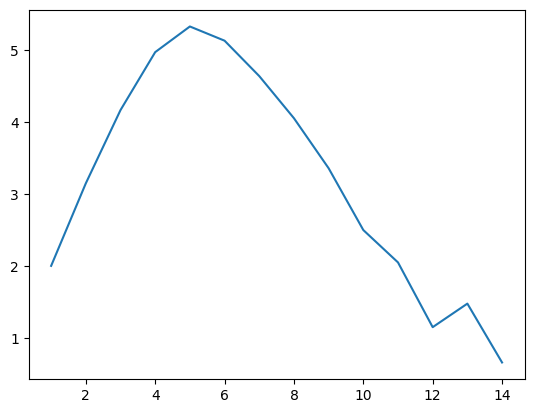

In [8]:
N = np.arange(1,15)
vol = np.array([n_ball(n, 50000) for n in N])
plt.plot(N, vol)

5\. **Monte Carlo integration with importance sampling**

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

With importance sampling $I\approx\frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{w(x_i)}\int_a^b w(x)dx$

In [17]:
def func(x):
  return 1/(np.sqrt(x)*(np.exp(x)+1))
def imp(x):
  return 1/np.sqrt(x)
def inversion(x):
  return np.square(x)/4

N=40000
w = npr.uniform(0, 2, N)
x = inversion(w)
I_w = mean_method(imp, N, 0, 1) #In this case for I_w we could have used the analytic result, which is 2
I = I_w/N*np.sum(func(x)/imp(x))
print(I)

0.843837828619195
